# Feature Selection Codealong

In this notebook we will try 3 methods of feature selection:
* Filtering by low multicollinearity
* Selecting via Permutation Importance
* Applying SequentialFeatureSelector to test many models and find the best combination of features.
* Using SelectFromModel in a Pipeline
The data is the engineered data we created in the last lecture.  However, instead of PCA, we will try some feature selection methods.  

Once again we will bin the target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from sklearn import set_config
set_config(transform_output='pandas')

import joblib
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [3]:
loaded = joblib.load('../Lecture 1/Data/engineered_student_data.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'columntransformer'])

In [4]:
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']
preprocessor = loaded['columntransformer']

X_train.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Semester,TotAlc,school/subject
15,1,17,U,1,T,3,3,other,other,reputation,father,1,2,0,0,0,0,1,0,1,1,0,4,3,4,1,4,4,1.609438,G1,5,GP mat
48,1,19,U,1,T,2,1,other,other,reputation,mother,1,1,0,0,0,0,0,1,1,1,0,5,3,4,1,4,4,2.397895,G2,5,GP por
259,1,18,U,0,T,1,1,other,services,home,father,2,1,0,0,0,0,0,0,1,1,1,3,3,2,1,2,3,1.098612,G2,3,MS por
28,0,15,U,0,T,4,2,health,other,other,mother,1,2,0,0,1,0,0,1,1,1,0,4,3,3,1,1,5,0.000000,G1,2,GP por
41,0,17,U,1,T,3,2,other,other,course,mother,1,2,0,0,0,0,1,0,1,1,0,5,3,4,1,3,3,1.098612,G1,4,GP por


# Process the Data

In [5]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_proc.shape

(2349, 52)

# Base Model

We will create a base model on all data to compare.

In [6]:
## Create and fit the initial model
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_proc, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



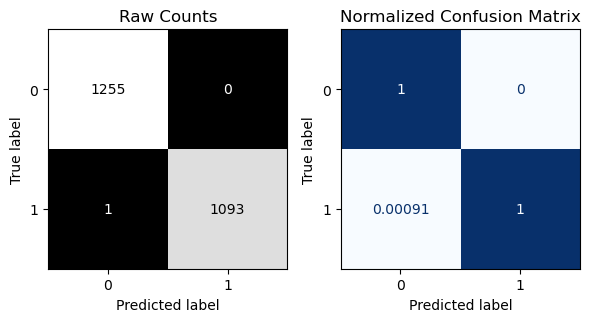


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       412
           1       0.93      0.86      0.89       371

    accuracy                           0.90       783
   macro avg       0.91      0.90      0.90       783
weighted avg       0.90      0.90      0.90       783



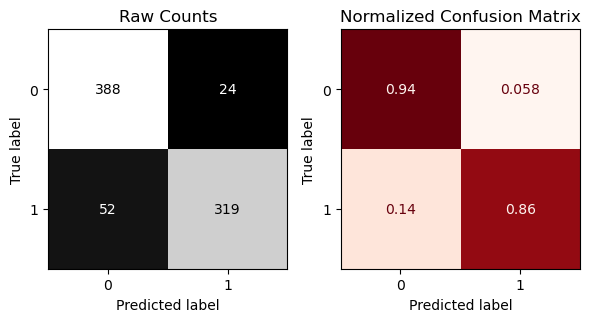

CPU times: total: 375 ms
Wall time: 430 ms


In [7]:
%%time
## Evaluate the intial model
evaluate_classification(rf_base, X_train_proc, y_train, X_test_proc, y_test)

# Filter Method: Multi-collinearity

In this section we will select features based on the correlation of each feature to the target.

1. We will join the training features and target.  We will use only training data to avoid peeking at the test data.
2. We will determine the correlations between each feature and the target
3. We will select only the features whose correlation exceeds a chosen threshold
4. We will fit a new model on only the features with higher correlation to the target and evaluate it.

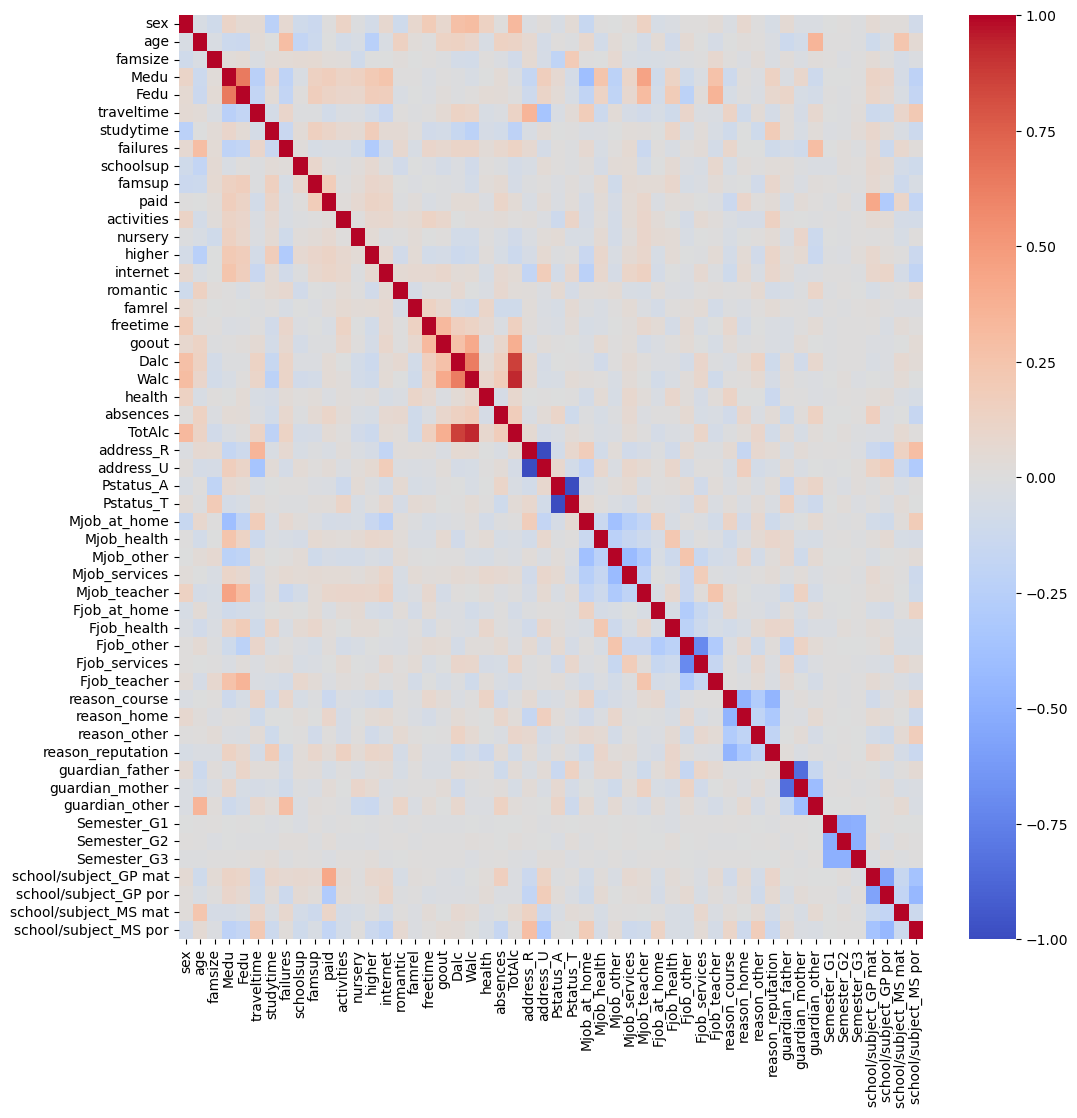

In [8]:
# Visualize Correlations

plt.figure(figsize=(12,12))
sns.heatmap(X_train_proc.corr(), cmap='coolwarm');

We are seeing come high correlations, especially with one-hot encode columns.  We will set a threshold of .7 to limit multicollinearity

In [9]:
## Import Some new packages
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

`SelectNonCollinear` is a class with will select the features more correlated with the target that are less correlated to other features.

f_classif is a metric from sklearn that determines the relationship between features in a classification model.  It uses ANOVA tests to determine this.

In [10]:
## Set a correlation threshold
threshold = .7

## Instantiate the non-collinear selector
selector =  SelectNonCollinear(correlation_threshold=threshold, scoring=f_classif)

## Fit Selector
selector.fit(X_train_proc.values, y_train.values)

## Use selector to subset the columns
X_train_non_col = X_train_proc.loc[:, selector.get_support()]
X_test_non_col = X_test_proc.loc[:, selector.get_support()]
print(X_train_non_col.shape)

(2349, 46)


## Fit a model with less collinear features.


In [11]:
## Create and fit a model on the higher correlated features
rf_corrs = RandomForestClassifier(random_state=42)

rf_corrs.fit(X_train_non_col, y_train.values)

RandomForestClassifier(random_state=42)

In [12]:
print(f'We reduced dimensionality by {X_train_proc.shape[1] - X_train_non_col.shape[1]}')

We reduced dimensionality by 6


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



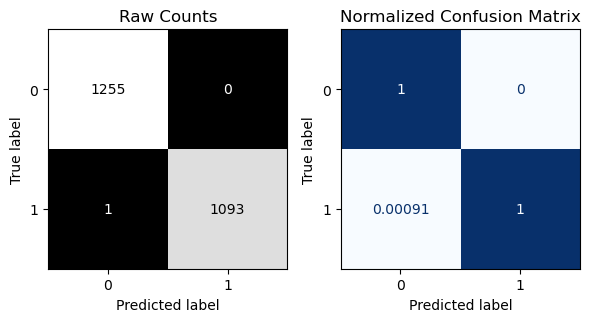


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       412
           1       0.91      0.88      0.90       371

    accuracy                           0.90       783
   macro avg       0.90      0.90      0.90       783
weighted avg       0.90      0.90      0.90       783



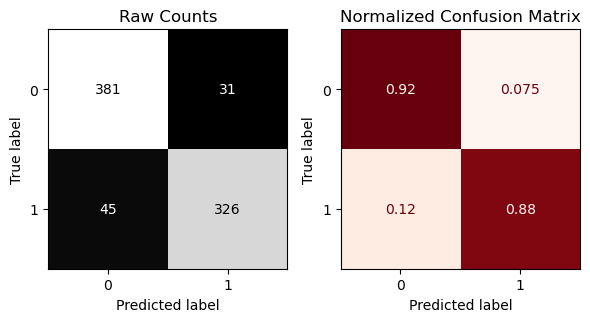

CPU times: total: 312 ms
Wall time: 396 ms


In [13]:
%%time
## Evaluate the correlation model

evaluate_classification(rf_corrs, X_train_non_col, y_train, X_test_non_col, y_test)

In [14]:
print(f'We reduced the number of features by {X_train_proc.shape[1] - X_train_non_col.shape[1]}')

We reduced the number of features by 6


# Embedded Method: Permutation Importance

<font color='red'> You will need to do this on Project 4 Part 1 </font>

In this section we will:
1. Create and fit an initial model
2. Determine feature importances using `permutation_importance()`
3. Create a Series using the discovered importances
4. Create a filter out of the Series using a chosen threshold
5. Use that filter to select which features to keep.
6. Fit a new model using the selected features.

In [15]:
## Calculate feature importances
importances = permutation_importance(rf_base, X_train_proc, y_train)

## Create a Series of Feature Importances
importances_df = pd.Series(importances['importances_mean'], index=rf_base.feature_names_in_)
importances_df.sort_values(ascending=False)

failures                 0.060877
school/subject_GP por    0.047765
Semester_G1              0.028438
Semester_G3              0.020094
absences                 0.012261
Semester_G2              0.011409
higher                   0.009451
school/subject_GP mat    0.003321
TotAlc                   0.002895
Medu                     0.002725
Fedu                     0.002639
school/subject_MS mat    0.001703
health                   0.001703
studytime                0.001618
goout                    0.001618
activities               0.001447
Mjob_at_home             0.001362
freetime                 0.001192
Mjob_services            0.001022
school/subject_MS por    0.000937
Dalc                     0.000937
internet                 0.000937
schoolsup                0.000681
Walc                     0.000596
reason_reputation        0.000426
nursery                  0.000426
address_R                0.000426
age                      0.000426
guardian_mother          0.000426
traveltime    

<Axes: >

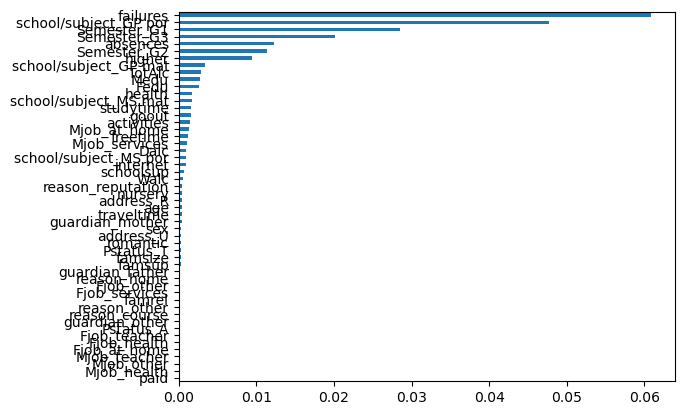

In [16]:
## Plot the importances
importances_df.sort_values().plot(kind='barh')

In [17]:
## Create a filter based on a threshold
threshold = 0
important_features = importances_df > threshold

## Use the filter to select features to keep
X_train_perm_sel = X_train_proc.loc[:,important_features]
X_test_perm_sel = X_test_proc.loc[:, important_features]
print(X_train_perm_sel.shape)
X_train_perm_sel.columns

(2349, 42)


Index(['sex', 'age', 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'TotAlc', 'address_R', 'address_U', 'Pstatus_T',
       'Mjob_at_home', 'Mjob_services', 'Fjob_other', 'Fjob_services',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'Semester_G1', 'Semester_G2', 'Semester_G3',
       'school/subject_GP mat', 'school/subject_GP por',
       'school/subject_MS mat', 'school/subject_MS por'],
      dtype='object')

## Fit a new model just on the more important features.

In [18]:
rf_perm_sel = RandomForestClassifier(random_state=42)
rf_perm_sel.fit(X_train_perm_sel, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



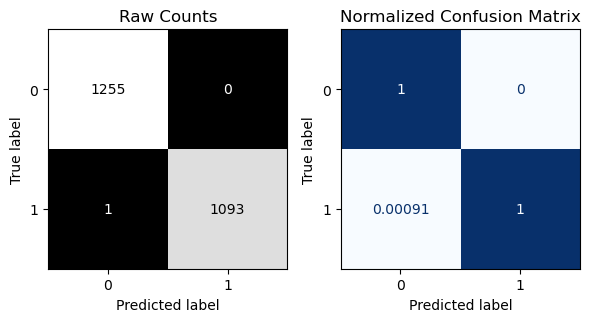


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       412
           1       0.92      0.87      0.90       371

    accuracy                           0.91       783
   macro avg       0.91      0.90      0.90       783
weighted avg       0.91      0.91      0.91       783



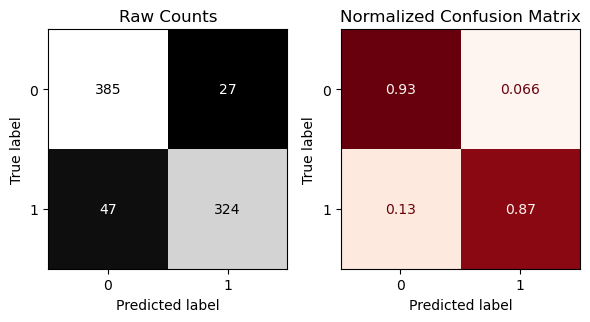

CPU times: total: 281 ms
Wall time: 390 ms


In [19]:
%%time
##Evaluate the model using permutation importance selected data
evaluate_classification(rf_perm_sel, X_train_perm_sel, y_train, X_test_perm_sel, y_test)

In [20]:
print(f'We reduced the number of features by {X_train_proc.shape[1] - X_train_perm_sel.shape[1]}')

We reduced the number of features by 10


# Embedded Method: Importance or Coefficients using `SelectFromModel` in a Pipeline

* This works with Linear and Tree models only

* Since SelectFromModel uses the inherent coefficients or feature importances of a model.  It has a .transform() method, it can be used in a pipeline!

In [21]:
## instantiate the selector with a model.
selector = SelectFromModel(rf_base)

## Put it in a pipeline between a preprocessor and another model
sel_pipe = make_pipeline(preprocessor, 
                         selector, 
                         RandomForestClassifier(random_state=42))

## Fit the pipeline
sel_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric', StandardScaler(),
                                                  Index(['sex', 'age', 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'TotAlc'],
      dtype='object')),
                                                 ('N...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'Semester',
       'school/subject'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



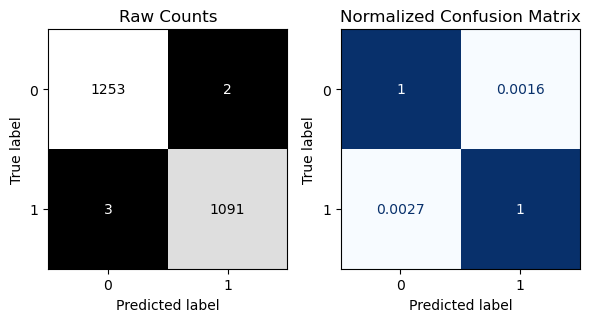


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       412
           1       0.86      0.85      0.85       371

    accuracy                           0.86       783
   macro avg       0.86      0.86      0.86       783
weighted avg       0.86      0.86      0.86       783



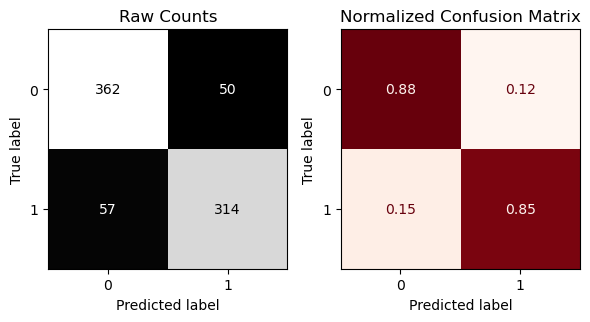

In [22]:
## Evaluate the pipeline model
evaluate_classification(sel_pipe, X_train, y_train, X_test, y_test)

# Wrapper Method: `SequentialFeatureSelection` Class

In this section we will use a class that will fit many models with many combinations of features and see which combination is best.  This is simple to code, but can take a very long time!

1. Instantiate and fit the SequentialFeatureSelector class.  We will use the base RandomForestClassifier we made earlier for this.
2. Extract the features that the class suggests that we keep and use them to filter our data
3. Fit and evaluate a new model on just those features.


**In all cases, the general flow is to identify the features to keep, subset the dataframe, then fit and evaluate a model on those features.**

In [23]:
## Decide on a number of features to keep
num_features = 40

## Instantiate the feature selector
feat_selector = SequentialFeatureSelector(rf_base, n_features_to_select=num_features,
                                          direction='forward', cv=2,
                                          n_jobs=-1)

## Fit the feature selector
feat_selector.fit(X_train_proc, y_train)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=40, n_jobs=-1)

In [24]:
## Extract the features suggested by the selector
features_to_keep = feat_selector.support_

## Use the filter to subset the features.
X_train_sel = X_train_proc.loc[:, features_to_keep]
X_test_sel = X_test_proc.loc[:, features_to_keep]

In [25]:
## Instanciate and fit a new model on just the features suggested by the selector
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_sel, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1255
           1       0.95      0.94      0.95      1094

    accuracy                           0.95      2349
   macro avg       0.95      0.95      0.95      2349
weighted avg       0.95      0.95      0.95      2349



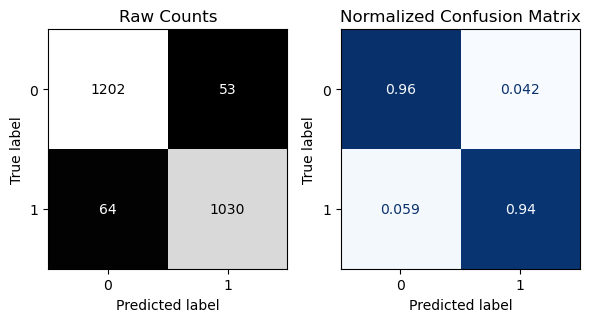


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       412
           1       0.92      0.88      0.90       371

    accuracy                           0.90       783
   macro avg       0.91      0.90      0.90       783
weighted avg       0.90      0.90      0.90       783



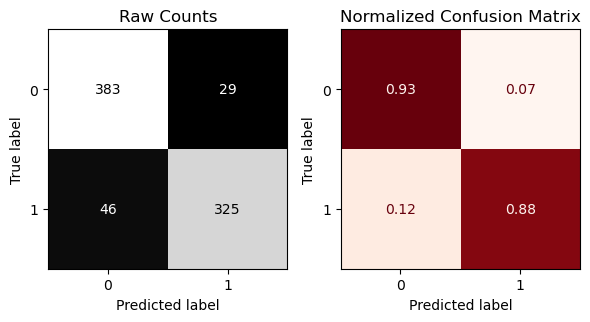

CPU times: total: 203 ms
Wall time: 464 ms


In [26]:
%%time
## Evaluate the model
evaluate_classification(rf_selected, X_train_sel, y_train, X_test_sel, y_test)

In [27]:
print(f'We reduced the dimensionality of the feature set by {X_train_proc.shape[1] - X_train_sel.shape[1]}')

We reduced the dimensionality of the feature set by 12


# Summary

In this notebook we implemented 3 methods for selecting features:

1. Selecting based on multicollinearity of features
2. Selecting based on the permutation importance of each feature
3. Selecting based on the suggestions of an Scikit-Learn wrapper class.

In all cases we were able to reduce the number of features without significantly hurting the model metrics.